# Dataset

You've seen this section of code from previous lessons. Here we're importing the MNIST dataset and using a convenient TensorFlow function to batch, scale, and One-Hot encode the data.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".", one_hot=True, reshape=False)

import tensorflow as tf

# Parameters
learning_rate = 0.00001
epochs = 10
batch_size = 128

# Number of samples to calculate validation and accuracy
# Decrease this if you're running out of memory to calculate accuracy
test_valid_size = 256

# Network Parameters
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.75  # Dropout, probability to keep units

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


### Weights and Biases

In [2]:
# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    'out': tf.Variable(tf.random_normal([1024, n_classes]))}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))}

### Convolutions
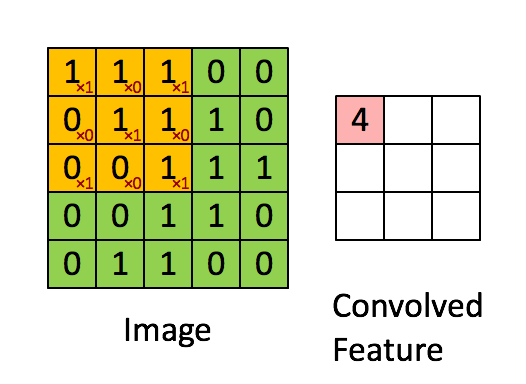

The above is an example of a convolution with a 3x3 filter and a stride of 1 being applied to data with a range of 0 to 1. The convolution for each 3x3 section is calculated against the weight, [[1, 0, 1], [0, 1, 0], [1, 0, 1]], then a bias is added to create the convolved feature on the right. In this case, the bias is zero. In TensorFlow, this is all done using tf.nn.conv2d() and tf.nn.bias_add().


In [3]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

The tf.nn.conv2d() function computes the convolution against weight W as shown above.

In TensorFlow, strides is an array of 4 elements; the first element in this array indicates the stride for batch and last element indicates stride for features. It's good practice to remove the batches or features you want to skip from the data set rather than use a stride to skip them. You can always set the first and last element to 1 in strides in order to use all batches and features.

The middle two elements are the strides for height and width respectively. I've mentioned stride as one number because you usually have a square stride where height = width. When someone says they are using a stride of 3, they usually mean tf.nn.conv2d(x, W, strides=[1, 3, 3, 1]).

To make life easier, the code is using tf.nn.bias_add() to add the bias. Using tf.add() doesn't work when the tensors aren't the same shape.

## Max Pooling
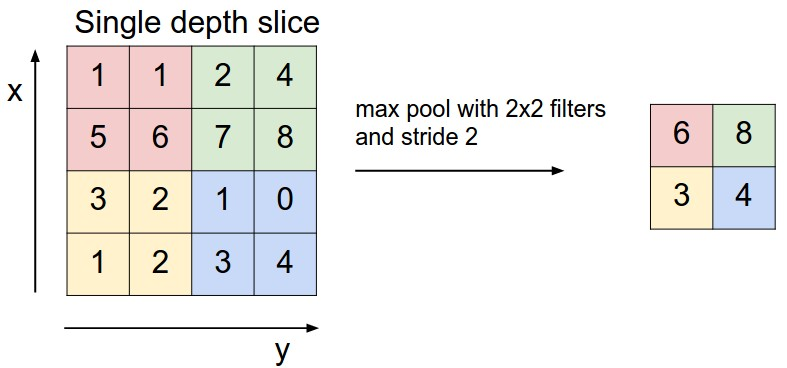

The above is an example of max pooling with a 2x2 filter and stride of 2. The left square is the input and the right square is the output. The four 2x2 colors in input represents each time the filter was applied to create the max on the right side. For example, [[1, 1], [5, 6]] becomes 6 and [[3, 2], [1, 2]] becomes 3.

In [4]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

## Model
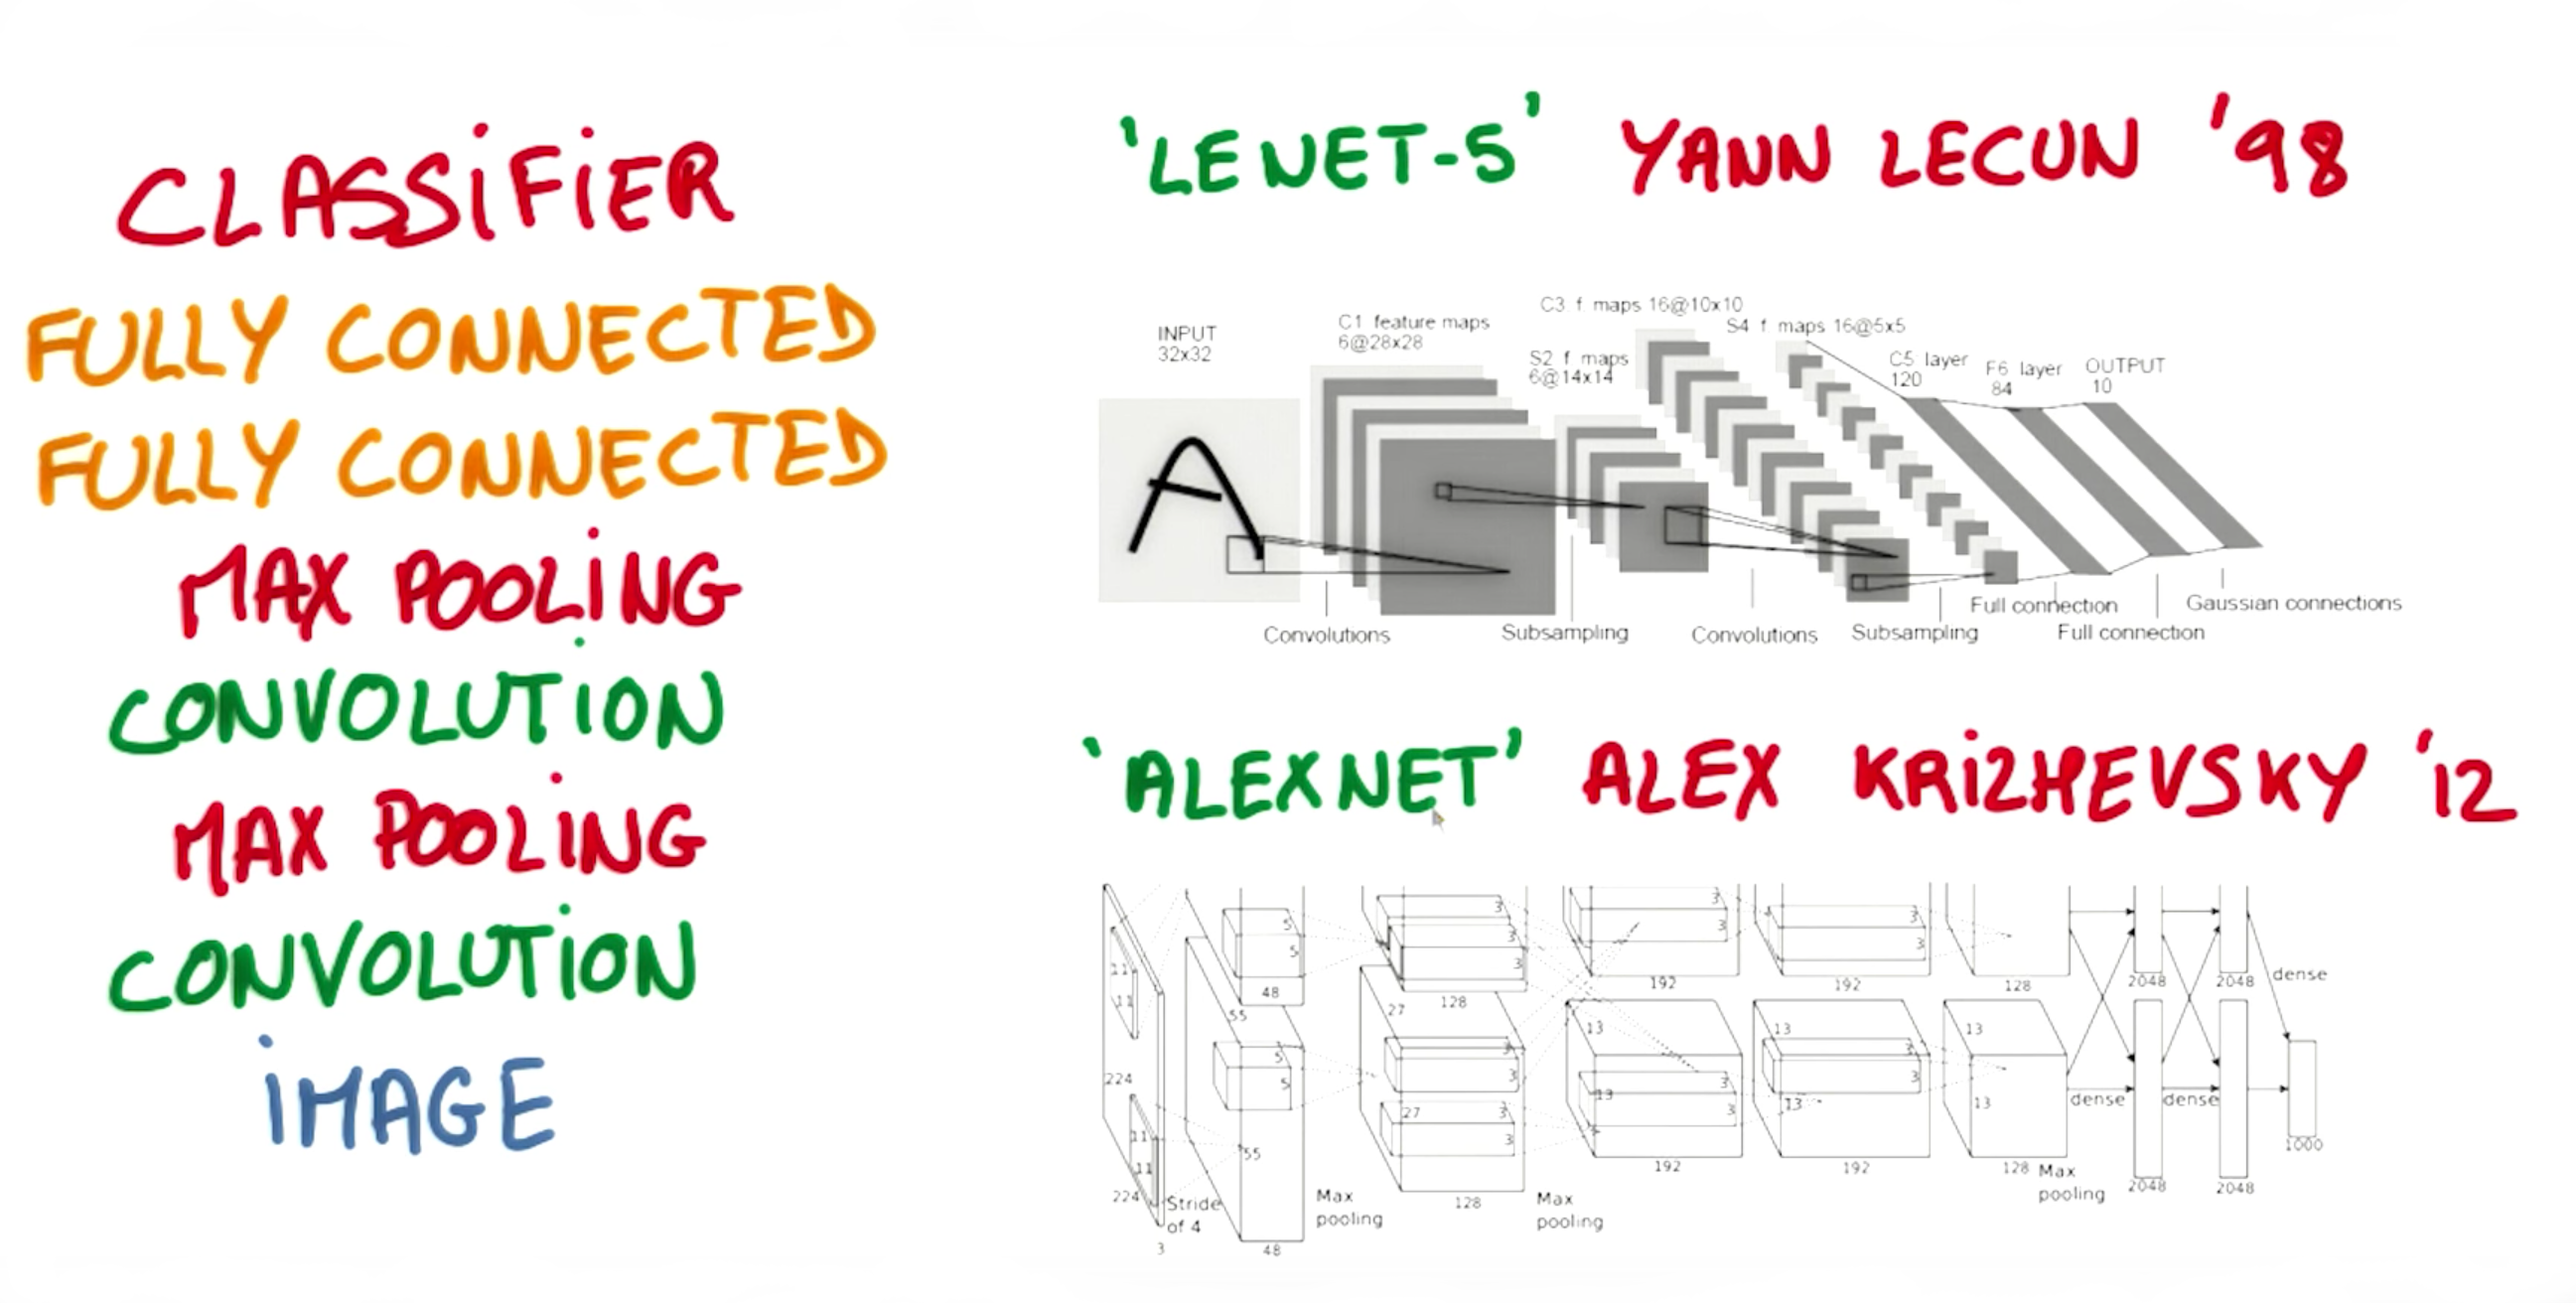

In the code below, we're creating 3 layers alternating between convolutions and max pooling followed by a fully connected and output layer. The transformation of each layer to new dimensions are shown in the comments. For example, the first layer shapes the images from 28x28x1 to 28x28x32 in the convolution step. Then next step applies max pooling, turning each sample into 14x14x32. All the layers are applied from conv1 to output, producing 10 class predictions.

In [5]:
def conv_net(x, weights, biases, dropout):
    # Layer 1 - 28*28*1 to 14*14*32
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    # Layer 2 - 14*14*32 to 7*7*64
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer - 7*7*64 to 1024
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output Layer - class prediction - 1024 to 10
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

### Session
Now let's run it!

In [6]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, 28, 28, 1])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# Model
logits = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(\
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)\
    .minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf. global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(epochs):
        for batch in range(mnist.train.num_examples//batch_size):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            sess.run(optimizer, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: dropout})

            # Calculate batch loss and accuracy
            loss = sess.run(cost, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: 1.})
            valid_acc = sess.run(accuracy, feed_dict={
                x: mnist.validation.images[:test_valid_size],
                y: mnist.validation.labels[:test_valid_size],
                keep_prob: 1.})

            print('Epoch {:>2}, Batch {:>3} -'
                  'Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                epoch + 1,
                batch + 1,
                loss,
                valid_acc))

    # Calculate Test Accuracy
    test_acc = sess.run(accuracy, feed_dict={
        x: mnist.test.images[:test_valid_size],
        y: mnist.test.labels[:test_valid_size],
        keep_prob: 1.})
    print('Testing Accuracy: {}'.format(test_acc))

Epoch  1, Batch   1 -Loss: 73196.9922 Validation Accuracy: 0.070312
Epoch  1, Batch   2 -Loss: 58315.5703 Validation Accuracy: 0.066406
Epoch  1, Batch   3 -Loss: 50748.0859 Validation Accuracy: 0.039062
Epoch  1, Batch   4 -Loss: 41130.0781 Validation Accuracy: 0.031250
Epoch  1, Batch   5 -Loss: 35066.1875 Validation Accuracy: 0.035156
Epoch  1, Batch   6 -Loss: 27924.3145 Validation Accuracy: 0.078125
Epoch  1, Batch   7 -Loss: 28127.7109 Validation Accuracy: 0.097656
Epoch  1, Batch   8 -Loss: 24956.7090 Validation Accuracy: 0.109375
Epoch  1, Batch   9 -Loss: 24617.7656 Validation Accuracy: 0.144531
Epoch  1, Batch  10 -Loss: 20709.0859 Validation Accuracy: 0.171875
Epoch  1, Batch  11 -Loss: 19001.5039 Validation Accuracy: 0.187500
Epoch  1, Batch  12 -Loss: 19531.8145 Validation Accuracy: 0.199219
Epoch  1, Batch  13 -Loss: 22790.1953 Validation Accuracy: 0.214844
Epoch  1, Batch  14 -Loss: 18273.1602 Validation Accuracy: 0.214844
Epoch  1, Batch  15 -Loss: 16867.4434 Validation

Epoch  1, Batch 122 -Loss:  3007.7239 Validation Accuracy: 0.636719
Epoch  1, Batch 123 -Loss:  3532.4043 Validation Accuracy: 0.632812
Epoch  1, Batch 124 -Loss:  3808.9583 Validation Accuracy: 0.632812
Epoch  1, Batch 125 -Loss:  5663.6641 Validation Accuracy: 0.628906
Epoch  1, Batch 126 -Loss:  3374.3215 Validation Accuracy: 0.625000
Epoch  1, Batch 127 -Loss:  3489.8232 Validation Accuracy: 0.628906
Epoch  1, Batch 128 -Loss:  2676.7695 Validation Accuracy: 0.625000
Epoch  1, Batch 129 -Loss:  4334.7661 Validation Accuracy: 0.625000
Epoch  1, Batch 130 -Loss:  4280.7974 Validation Accuracy: 0.628906
Epoch  1, Batch 131 -Loss:  3498.6472 Validation Accuracy: 0.636719
Epoch  1, Batch 132 -Loss:  3503.0522 Validation Accuracy: 0.636719
Epoch  1, Batch 133 -Loss:  4605.8364 Validation Accuracy: 0.632812
Epoch  1, Batch 134 -Loss:  3837.8950 Validation Accuracy: 0.621094
Epoch  1, Batch 135 -Loss:  2571.3518 Validation Accuracy: 0.628906
Epoch  1, Batch 136 -Loss:  3923.1008 Validation

Epoch  1, Batch 243 -Loss:  2134.4062 Validation Accuracy: 0.714844
Epoch  1, Batch 244 -Loss:  2476.3330 Validation Accuracy: 0.722656
Epoch  1, Batch 245 -Loss:  1474.9166 Validation Accuracy: 0.703125
Epoch  1, Batch 246 -Loss:  1979.3162 Validation Accuracy: 0.714844
Epoch  1, Batch 247 -Loss:  2733.2688 Validation Accuracy: 0.707031
Epoch  1, Batch 248 -Loss:  2558.6812 Validation Accuracy: 0.699219
Epoch  1, Batch 249 -Loss:  3035.3030 Validation Accuracy: 0.707031
Epoch  1, Batch 250 -Loss:  2497.5015 Validation Accuracy: 0.703125
Epoch  1, Batch 251 -Loss:  2219.7888 Validation Accuracy: 0.707031
Epoch  1, Batch 252 -Loss:  2586.4966 Validation Accuracy: 0.703125
Epoch  1, Batch 253 -Loss:  1529.1184 Validation Accuracy: 0.707031
Epoch  1, Batch 254 -Loss:  2355.6172 Validation Accuracy: 0.710938
Epoch  1, Batch 255 -Loss:  2225.5913 Validation Accuracy: 0.710938
Epoch  1, Batch 256 -Loss:  2132.8972 Validation Accuracy: 0.710938
Epoch  1, Batch 257 -Loss:  1472.2615 Validation

Epoch  1, Batch 364 -Loss:  1689.9036 Validation Accuracy: 0.722656
Epoch  1, Batch 365 -Loss:  1691.6554 Validation Accuracy: 0.722656
Epoch  1, Batch 366 -Loss:  1313.4839 Validation Accuracy: 0.726562
Epoch  1, Batch 367 -Loss:  1501.1034 Validation Accuracy: 0.734375
Epoch  1, Batch 368 -Loss:  1649.6049 Validation Accuracy: 0.730469
Epoch  1, Batch 369 -Loss:  1341.9897 Validation Accuracy: 0.730469
Epoch  1, Batch 370 -Loss:  2296.3286 Validation Accuracy: 0.730469
Epoch  1, Batch 371 -Loss:  1591.0173 Validation Accuracy: 0.726562
Epoch  1, Batch 372 -Loss:  1356.6880 Validation Accuracy: 0.726562
Epoch  1, Batch 373 -Loss:  1722.5541 Validation Accuracy: 0.734375
Epoch  1, Batch 374 -Loss:  2134.5371 Validation Accuracy: 0.730469
Epoch  1, Batch 375 -Loss:  1960.0956 Validation Accuracy: 0.730469
Epoch  1, Batch 376 -Loss:  1156.9478 Validation Accuracy: 0.722656
Epoch  1, Batch 377 -Loss:  1699.3320 Validation Accuracy: 0.734375
Epoch  1, Batch 378 -Loss:  1912.5203 Validation

Epoch  2, Batch  56 -Loss:  1411.9541 Validation Accuracy: 0.750000
Epoch  2, Batch  57 -Loss:   880.4119 Validation Accuracy: 0.746094
Epoch  2, Batch  58 -Loss:  1169.1323 Validation Accuracy: 0.742188
Epoch  2, Batch  59 -Loss:  2010.9697 Validation Accuracy: 0.738281
Epoch  2, Batch  60 -Loss:  1199.8701 Validation Accuracy: 0.750000
Epoch  2, Batch  61 -Loss:  1027.7848 Validation Accuracy: 0.746094
Epoch  2, Batch  62 -Loss:  1154.7097 Validation Accuracy: 0.753906
Epoch  2, Batch  63 -Loss:  1053.6733 Validation Accuracy: 0.753906
Epoch  2, Batch  64 -Loss:   825.1434 Validation Accuracy: 0.750000
Epoch  2, Batch  65 -Loss:  1225.4369 Validation Accuracy: 0.753906
Epoch  2, Batch  66 -Loss:  1848.9255 Validation Accuracy: 0.750000
Epoch  2, Batch  67 -Loss:  1496.6937 Validation Accuracy: 0.746094
Epoch  2, Batch  68 -Loss:  1002.1368 Validation Accuracy: 0.750000
Epoch  2, Batch  69 -Loss:  1356.3232 Validation Accuracy: 0.757812
Epoch  2, Batch  70 -Loss:   899.5938 Validation

Epoch  2, Batch 177 -Loss:   616.5825 Validation Accuracy: 0.753906
Epoch  2, Batch 178 -Loss:  1105.6409 Validation Accuracy: 0.757812
Epoch  2, Batch 179 -Loss:   886.2091 Validation Accuracy: 0.757812
Epoch  2, Batch 180 -Loss:  1377.4742 Validation Accuracy: 0.757812
Epoch  2, Batch 181 -Loss:   979.4077 Validation Accuracy: 0.757812
Epoch  2, Batch 182 -Loss:  1258.4756 Validation Accuracy: 0.757812
Epoch  2, Batch 183 -Loss:   883.0847 Validation Accuracy: 0.757812
Epoch  2, Batch 184 -Loss:  1163.8544 Validation Accuracy: 0.753906
Epoch  2, Batch 185 -Loss:   921.9184 Validation Accuracy: 0.757812
Epoch  2, Batch 186 -Loss:  1613.8706 Validation Accuracy: 0.761719
Epoch  2, Batch 187 -Loss:   725.1135 Validation Accuracy: 0.761719
Epoch  2, Batch 188 -Loss:   707.8433 Validation Accuracy: 0.761719
Epoch  2, Batch 189 -Loss:  1407.4014 Validation Accuracy: 0.761719
Epoch  2, Batch 190 -Loss:   882.0426 Validation Accuracy: 0.761719
Epoch  2, Batch 191 -Loss:  1558.7487 Validation

Epoch  2, Batch 298 -Loss:  1037.3669 Validation Accuracy: 0.769531
Epoch  2, Batch 299 -Loss:   568.0295 Validation Accuracy: 0.769531
Epoch  2, Batch 300 -Loss:   702.4991 Validation Accuracy: 0.765625
Epoch  2, Batch 301 -Loss:   753.7141 Validation Accuracy: 0.765625
Epoch  2, Batch 302 -Loss:   686.0520 Validation Accuracy: 0.765625
Epoch  2, Batch 303 -Loss:   926.1056 Validation Accuracy: 0.761719
Epoch  2, Batch 304 -Loss:   573.8906 Validation Accuracy: 0.757812
Epoch  2, Batch 305 -Loss:  1012.7622 Validation Accuracy: 0.750000
Epoch  2, Batch 306 -Loss:   974.8700 Validation Accuracy: 0.757812
Epoch  2, Batch 307 -Loss:   691.7393 Validation Accuracy: 0.761719
Epoch  2, Batch 308 -Loss:  1264.1064 Validation Accuracy: 0.765625
Epoch  2, Batch 309 -Loss:   889.7998 Validation Accuracy: 0.757812
Epoch  2, Batch 310 -Loss:  1051.7610 Validation Accuracy: 0.757812
Epoch  2, Batch 311 -Loss:   988.9722 Validation Accuracy: 0.761719
Epoch  2, Batch 312 -Loss:   837.9846 Validation

Epoch  2, Batch 419 -Loss:   865.0304 Validation Accuracy: 0.761719
Epoch  2, Batch 420 -Loss:   345.9925 Validation Accuracy: 0.761719
Epoch  2, Batch 421 -Loss:   524.6097 Validation Accuracy: 0.769531
Epoch  2, Batch 422 -Loss:   771.1991 Validation Accuracy: 0.769531
Epoch  2, Batch 423 -Loss:  1140.0048 Validation Accuracy: 0.765625
Epoch  2, Batch 424 -Loss:   721.6936 Validation Accuracy: 0.757812
Epoch  2, Batch 425 -Loss:   991.4152 Validation Accuracy: 0.773438
Epoch  2, Batch 426 -Loss:   625.5283 Validation Accuracy: 0.765625
Epoch  2, Batch 427 -Loss:   822.6110 Validation Accuracy: 0.773438
Epoch  2, Batch 428 -Loss:   903.3876 Validation Accuracy: 0.765625
Epoch  2, Batch 429 -Loss:   966.6659 Validation Accuracy: 0.769531
Epoch  3, Batch   1 -Loss:   851.9565 Validation Accuracy: 0.773438
Epoch  3, Batch   2 -Loss:   890.9338 Validation Accuracy: 0.765625
Epoch  3, Batch   3 -Loss:   809.6612 Validation Accuracy: 0.777344
Epoch  3, Batch   4 -Loss:   922.5075 Validation

Epoch  3, Batch 111 -Loss:   610.5127 Validation Accuracy: 0.773438
Epoch  3, Batch 112 -Loss:   424.4571 Validation Accuracy: 0.777344
Epoch  3, Batch 113 -Loss:   490.9621 Validation Accuracy: 0.773438
Epoch  3, Batch 114 -Loss:   810.2208 Validation Accuracy: 0.773438
Epoch  3, Batch 115 -Loss:  1011.0959 Validation Accuracy: 0.773438
Epoch  3, Batch 116 -Loss:   695.1796 Validation Accuracy: 0.777344
Epoch  3, Batch 117 -Loss:   804.3671 Validation Accuracy: 0.777344
Epoch  3, Batch 118 -Loss:   588.0433 Validation Accuracy: 0.777344
Epoch  3, Batch 119 -Loss:   981.5137 Validation Accuracy: 0.777344
Epoch  3, Batch 120 -Loss:   849.5301 Validation Accuracy: 0.777344
Epoch  3, Batch 121 -Loss:  1143.6941 Validation Accuracy: 0.777344
Epoch  3, Batch 122 -Loss:   824.3521 Validation Accuracy: 0.773438
Epoch  3, Batch 123 -Loss:   933.6970 Validation Accuracy: 0.777344
Epoch  3, Batch 124 -Loss:   763.7671 Validation Accuracy: 0.773438
Epoch  3, Batch 125 -Loss:   649.5121 Validation

Epoch  3, Batch 232 -Loss:   596.7623 Validation Accuracy: 0.785156
Epoch  3, Batch 233 -Loss:   661.9968 Validation Accuracy: 0.785156
Epoch  3, Batch 234 -Loss:   556.5379 Validation Accuracy: 0.785156
Epoch  3, Batch 235 -Loss:  1052.5187 Validation Accuracy: 0.789062
Epoch  3, Batch 236 -Loss:   578.5301 Validation Accuracy: 0.792969
Epoch  3, Batch 237 -Loss:   711.6161 Validation Accuracy: 0.781250
Epoch  3, Batch 238 -Loss:   627.3182 Validation Accuracy: 0.785156
Epoch  3, Batch 239 -Loss:   588.2642 Validation Accuracy: 0.785156
Epoch  3, Batch 240 -Loss:   556.8729 Validation Accuracy: 0.785156
Epoch  3, Batch 241 -Loss:   849.7111 Validation Accuracy: 0.789062
Epoch  3, Batch 242 -Loss:   374.9777 Validation Accuracy: 0.792969
Epoch  3, Batch 243 -Loss:   787.7766 Validation Accuracy: 0.792969
Epoch  3, Batch 244 -Loss:   871.9045 Validation Accuracy: 0.785156
Epoch  3, Batch 245 -Loss:   689.1165 Validation Accuracy: 0.789062
Epoch  3, Batch 246 -Loss:   540.4983 Validation

Epoch  3, Batch 353 -Loss:   591.6772 Validation Accuracy: 0.781250
Epoch  3, Batch 354 -Loss:   531.5282 Validation Accuracy: 0.781250
Epoch  3, Batch 355 -Loss:   654.4451 Validation Accuracy: 0.781250
Epoch  3, Batch 356 -Loss:   521.2186 Validation Accuracy: 0.781250
Epoch  3, Batch 357 -Loss:   576.3878 Validation Accuracy: 0.785156
Epoch  3, Batch 358 -Loss:   774.2668 Validation Accuracy: 0.785156
Epoch  3, Batch 359 -Loss:   772.6196 Validation Accuracy: 0.789062
Epoch  3, Batch 360 -Loss:   743.4790 Validation Accuracy: 0.785156
Epoch  3, Batch 361 -Loss:   944.4147 Validation Accuracy: 0.792969
Epoch  3, Batch 362 -Loss:   837.0132 Validation Accuracy: 0.785156
Epoch  3, Batch 363 -Loss:   800.4897 Validation Accuracy: 0.781250
Epoch  3, Batch 364 -Loss:   766.4908 Validation Accuracy: 0.785156
Epoch  3, Batch 365 -Loss:   931.6891 Validation Accuracy: 0.789062
Epoch  3, Batch 366 -Loss:   735.6504 Validation Accuracy: 0.789062
Epoch  3, Batch 367 -Loss:   553.5779 Validation

Epoch  4, Batch  45 -Loss:   462.5374 Validation Accuracy: 0.796875
Epoch  4, Batch  46 -Loss:   469.9709 Validation Accuracy: 0.796875
Epoch  4, Batch  47 -Loss:   686.5197 Validation Accuracy: 0.792969
Epoch  4, Batch  48 -Loss:   617.0498 Validation Accuracy: 0.792969
Epoch  4, Batch  49 -Loss:   715.6336 Validation Accuracy: 0.789062
Epoch  4, Batch  50 -Loss:   850.7838 Validation Accuracy: 0.792969
Epoch  4, Batch  51 -Loss:   506.5699 Validation Accuracy: 0.796875
Epoch  4, Batch  52 -Loss:   688.6440 Validation Accuracy: 0.796875
Epoch  4, Batch  53 -Loss:   491.2024 Validation Accuracy: 0.800781
Epoch  4, Batch  54 -Loss:   548.8156 Validation Accuracy: 0.800781
Epoch  4, Batch  55 -Loss:   490.8428 Validation Accuracy: 0.804688
Epoch  4, Batch  56 -Loss:   493.2549 Validation Accuracy: 0.796875
Epoch  4, Batch  57 -Loss:   600.0520 Validation Accuracy: 0.800781
Epoch  4, Batch  58 -Loss:   654.7192 Validation Accuracy: 0.792969
Epoch  4, Batch  59 -Loss:   640.7740 Validation

Epoch  4, Batch 166 -Loss:   567.4975 Validation Accuracy: 0.800781
Epoch  4, Batch 167 -Loss:   680.5286 Validation Accuracy: 0.796875
Epoch  4, Batch 168 -Loss:   691.6699 Validation Accuracy: 0.800781
Epoch  4, Batch 169 -Loss:   437.2103 Validation Accuracy: 0.800781
Epoch  4, Batch 170 -Loss:   748.5189 Validation Accuracy: 0.800781
Epoch  4, Batch 171 -Loss:   765.0371 Validation Accuracy: 0.796875
Epoch  4, Batch 172 -Loss:   601.3740 Validation Accuracy: 0.800781
Epoch  4, Batch 173 -Loss:   402.9990 Validation Accuracy: 0.800781
Epoch  4, Batch 174 -Loss:   743.5754 Validation Accuracy: 0.800781
Epoch  4, Batch 175 -Loss:   473.6346 Validation Accuracy: 0.800781
Epoch  4, Batch 176 -Loss:   703.3003 Validation Accuracy: 0.796875
Epoch  4, Batch 177 -Loss:   505.4523 Validation Accuracy: 0.800781
Epoch  4, Batch 178 -Loss:   525.9046 Validation Accuracy: 0.796875
Epoch  4, Batch 179 -Loss:   721.1021 Validation Accuracy: 0.796875
Epoch  4, Batch 180 -Loss:   308.6294 Validation

Epoch  4, Batch 287 -Loss:   467.6866 Validation Accuracy: 0.796875
Epoch  4, Batch 288 -Loss:   655.6166 Validation Accuracy: 0.796875
Epoch  4, Batch 289 -Loss:   652.7103 Validation Accuracy: 0.796875
Epoch  4, Batch 290 -Loss:   558.7461 Validation Accuracy: 0.796875
Epoch  4, Batch 291 -Loss:   426.5811 Validation Accuracy: 0.796875
Epoch  4, Batch 292 -Loss:   292.8355 Validation Accuracy: 0.796875
Epoch  4, Batch 293 -Loss:   388.2895 Validation Accuracy: 0.796875
Epoch  4, Batch 294 -Loss:   713.8892 Validation Accuracy: 0.792969
Epoch  4, Batch 295 -Loss:   312.3171 Validation Accuracy: 0.792969
Epoch  4, Batch 296 -Loss:   467.5516 Validation Accuracy: 0.796875
Epoch  4, Batch 297 -Loss:   476.7621 Validation Accuracy: 0.796875
Epoch  4, Batch 298 -Loss:   508.6614 Validation Accuracy: 0.796875
Epoch  4, Batch 299 -Loss:   579.8101 Validation Accuracy: 0.796875
Epoch  4, Batch 300 -Loss:   582.2498 Validation Accuracy: 0.796875
Epoch  4, Batch 301 -Loss:   518.8330 Validation

Epoch  4, Batch 408 -Loss:   492.9423 Validation Accuracy: 0.789062
Epoch  4, Batch 409 -Loss:   449.0120 Validation Accuracy: 0.792969
Epoch  4, Batch 410 -Loss:   420.7691 Validation Accuracy: 0.789062
Epoch  4, Batch 411 -Loss:   449.8771 Validation Accuracy: 0.792969
Epoch  4, Batch 412 -Loss:   740.2333 Validation Accuracy: 0.792969
Epoch  4, Batch 413 -Loss:   528.6801 Validation Accuracy: 0.796875
Epoch  4, Batch 414 -Loss:   382.7732 Validation Accuracy: 0.796875
Epoch  4, Batch 415 -Loss:   493.8941 Validation Accuracy: 0.792969
Epoch  4, Batch 416 -Loss:   509.2935 Validation Accuracy: 0.796875
Epoch  4, Batch 417 -Loss:   311.4330 Validation Accuracy: 0.796875
Epoch  4, Batch 418 -Loss:   636.2371 Validation Accuracy: 0.796875
Epoch  4, Batch 419 -Loss:   441.6381 Validation Accuracy: 0.796875
Epoch  4, Batch 420 -Loss:   665.5134 Validation Accuracy: 0.796875
Epoch  4, Batch 421 -Loss:   392.2391 Validation Accuracy: 0.796875
Epoch  4, Batch 422 -Loss:   548.7963 Validation

Epoch  5, Batch 100 -Loss:   359.9615 Validation Accuracy: 0.808594
Epoch  5, Batch 101 -Loss:   436.9504 Validation Accuracy: 0.808594
Epoch  5, Batch 102 -Loss:   619.1176 Validation Accuracy: 0.808594
Epoch  5, Batch 103 -Loss:   487.8934 Validation Accuracy: 0.808594
Epoch  5, Batch 104 -Loss:   284.5311 Validation Accuracy: 0.808594
Epoch  5, Batch 105 -Loss:   533.2857 Validation Accuracy: 0.804688
Epoch  5, Batch 106 -Loss:   514.1215 Validation Accuracy: 0.804688
Epoch  5, Batch 107 -Loss:   331.5576 Validation Accuracy: 0.808594
Epoch  5, Batch 108 -Loss:   530.8466 Validation Accuracy: 0.808594
Epoch  5, Batch 109 -Loss:   248.1783 Validation Accuracy: 0.808594
Epoch  5, Batch 110 -Loss:   544.4016 Validation Accuracy: 0.808594
Epoch  5, Batch 111 -Loss:   405.7422 Validation Accuracy: 0.808594
Epoch  5, Batch 112 -Loss:   458.1702 Validation Accuracy: 0.808594
Epoch  5, Batch 113 -Loss:   393.8357 Validation Accuracy: 0.808594
Epoch  5, Batch 114 -Loss:   820.5480 Validation

Epoch  5, Batch 221 -Loss:   498.0458 Validation Accuracy: 0.812500
Epoch  5, Batch 222 -Loss:   476.4599 Validation Accuracy: 0.808594
Epoch  5, Batch 223 -Loss:   347.7351 Validation Accuracy: 0.808594
Epoch  5, Batch 224 -Loss:   375.2378 Validation Accuracy: 0.808594
Epoch  5, Batch 225 -Loss:   527.7935 Validation Accuracy: 0.808594
Epoch  5, Batch 226 -Loss:   298.0433 Validation Accuracy: 0.804688
Epoch  5, Batch 227 -Loss:   524.3573 Validation Accuracy: 0.804688
Epoch  5, Batch 228 -Loss:   387.6151 Validation Accuracy: 0.804688
Epoch  5, Batch 229 -Loss:   252.0392 Validation Accuracy: 0.804688
Epoch  5, Batch 230 -Loss:   550.0363 Validation Accuracy: 0.804688
Epoch  5, Batch 231 -Loss:   321.0899 Validation Accuracy: 0.808594
Epoch  5, Batch 232 -Loss:   602.0663 Validation Accuracy: 0.804688
Epoch  5, Batch 233 -Loss:   589.4169 Validation Accuracy: 0.804688
Epoch  5, Batch 234 -Loss:   561.7587 Validation Accuracy: 0.804688
Epoch  5, Batch 235 -Loss:   422.3936 Validation

Epoch  5, Batch 342 -Loss:   729.5699 Validation Accuracy: 0.820312
Epoch  5, Batch 343 -Loss:   506.9310 Validation Accuracy: 0.820312
Epoch  5, Batch 344 -Loss:   678.3527 Validation Accuracy: 0.820312
Epoch  5, Batch 345 -Loss:   545.1774 Validation Accuracy: 0.824219
Epoch  5, Batch 346 -Loss:   579.6760 Validation Accuracy: 0.824219
Epoch  5, Batch 347 -Loss:   405.4351 Validation Accuracy: 0.824219
Epoch  5, Batch 348 -Loss:   333.4950 Validation Accuracy: 0.820312
Epoch  5, Batch 349 -Loss:   486.1176 Validation Accuracy: 0.820312
Epoch  5, Batch 350 -Loss:   459.9027 Validation Accuracy: 0.820312
Epoch  5, Batch 351 -Loss:   362.7975 Validation Accuracy: 0.820312
Epoch  5, Batch 352 -Loss:   321.6920 Validation Accuracy: 0.824219
Epoch  5, Batch 353 -Loss:   423.9291 Validation Accuracy: 0.820312
Epoch  5, Batch 354 -Loss:   472.0578 Validation Accuracy: 0.824219
Epoch  5, Batch 355 -Loss:   371.9673 Validation Accuracy: 0.820312
Epoch  5, Batch 356 -Loss:   301.0101 Validation

Epoch  6, Batch  34 -Loss:   412.5467 Validation Accuracy: 0.820312
Epoch  6, Batch  35 -Loss:   561.1339 Validation Accuracy: 0.824219
Epoch  6, Batch  36 -Loss:   363.1905 Validation Accuracy: 0.820312
Epoch  6, Batch  37 -Loss:   373.0250 Validation Accuracy: 0.824219
Epoch  6, Batch  38 -Loss:   415.5731 Validation Accuracy: 0.824219
Epoch  6, Batch  39 -Loss:   428.7374 Validation Accuracy: 0.820312
Epoch  6, Batch  40 -Loss:   657.5495 Validation Accuracy: 0.816406
Epoch  6, Batch  41 -Loss:   367.0942 Validation Accuracy: 0.812500
Epoch  6, Batch  42 -Loss:   237.3533 Validation Accuracy: 0.824219
Epoch  6, Batch  43 -Loss:   367.4722 Validation Accuracy: 0.820312
Epoch  6, Batch  44 -Loss:   382.0491 Validation Accuracy: 0.816406
Epoch  6, Batch  45 -Loss:   550.4491 Validation Accuracy: 0.812500
Epoch  6, Batch  46 -Loss:   380.3298 Validation Accuracy: 0.816406
Epoch  6, Batch  47 -Loss:   432.2544 Validation Accuracy: 0.812500
Epoch  6, Batch  48 -Loss:   361.1665 Validation

Epoch  6, Batch 155 -Loss:   289.2316 Validation Accuracy: 0.816406
Epoch  6, Batch 156 -Loss:   296.8040 Validation Accuracy: 0.820312
Epoch  6, Batch 157 -Loss:   406.1794 Validation Accuracy: 0.816406
Epoch  6, Batch 158 -Loss:   405.2360 Validation Accuracy: 0.816406
Epoch  6, Batch 159 -Loss:   305.1013 Validation Accuracy: 0.812500
Epoch  6, Batch 160 -Loss:   313.4387 Validation Accuracy: 0.812500
Epoch  6, Batch 161 -Loss:   136.9146 Validation Accuracy: 0.816406
Epoch  6, Batch 162 -Loss:   430.1805 Validation Accuracy: 0.820312
Epoch  6, Batch 163 -Loss:   387.9199 Validation Accuracy: 0.820312
Epoch  6, Batch 164 -Loss:   445.7505 Validation Accuracy: 0.816406
Epoch  6, Batch 165 -Loss:   558.7817 Validation Accuracy: 0.820312
Epoch  6, Batch 166 -Loss:   411.0564 Validation Accuracy: 0.820312
Epoch  6, Batch 167 -Loss:   480.8358 Validation Accuracy: 0.820312
Epoch  6, Batch 168 -Loss:   402.8436 Validation Accuracy: 0.824219
Epoch  6, Batch 169 -Loss:   656.2889 Validation

Epoch  6, Batch 276 -Loss:   378.1125 Validation Accuracy: 0.824219
Epoch  6, Batch 277 -Loss:   319.5771 Validation Accuracy: 0.820312
Epoch  6, Batch 278 -Loss:   234.3009 Validation Accuracy: 0.828125
Epoch  6, Batch 279 -Loss:   229.7664 Validation Accuracy: 0.828125
Epoch  6, Batch 280 -Loss:   411.9947 Validation Accuracy: 0.828125
Epoch  6, Batch 281 -Loss:   310.9771 Validation Accuracy: 0.820312
Epoch  6, Batch 282 -Loss:   408.6753 Validation Accuracy: 0.824219
Epoch  6, Batch 283 -Loss:   344.4415 Validation Accuracy: 0.820312
Epoch  6, Batch 284 -Loss:   572.8434 Validation Accuracy: 0.820312
Epoch  6, Batch 285 -Loss:   292.9371 Validation Accuracy: 0.816406
Epoch  6, Batch 286 -Loss:   339.5723 Validation Accuracy: 0.816406
Epoch  6, Batch 287 -Loss:   494.8413 Validation Accuracy: 0.824219
Epoch  6, Batch 288 -Loss:   543.9561 Validation Accuracy: 0.824219
Epoch  6, Batch 289 -Loss:   454.3552 Validation Accuracy: 0.824219
Epoch  6, Batch 290 -Loss:   272.3025 Validation

Epoch  6, Batch 397 -Loss:   492.0654 Validation Accuracy: 0.808594
Epoch  6, Batch 398 -Loss:   442.9451 Validation Accuracy: 0.808594
Epoch  6, Batch 399 -Loss:   332.4669 Validation Accuracy: 0.808594
Epoch  6, Batch 400 -Loss:   220.3984 Validation Accuracy: 0.812500
Epoch  6, Batch 401 -Loss:   265.4153 Validation Accuracy: 0.812500
Epoch  6, Batch 402 -Loss:   476.4807 Validation Accuracy: 0.812500
Epoch  6, Batch 403 -Loss:   493.0156 Validation Accuracy: 0.820312
Epoch  6, Batch 404 -Loss:   249.3338 Validation Accuracy: 0.816406
Epoch  6, Batch 405 -Loss:   456.0549 Validation Accuracy: 0.816406
Epoch  6, Batch 406 -Loss:   501.8823 Validation Accuracy: 0.820312
Epoch  6, Batch 407 -Loss:   444.4715 Validation Accuracy: 0.820312
Epoch  6, Batch 408 -Loss:   593.0848 Validation Accuracy: 0.816406
Epoch  6, Batch 409 -Loss:   512.5947 Validation Accuracy: 0.816406
Epoch  6, Batch 410 -Loss:   427.1137 Validation Accuracy: 0.816406
Epoch  6, Batch 411 -Loss:   260.0696 Validation

Epoch  7, Batch  89 -Loss:   330.7277 Validation Accuracy: 0.808594
Epoch  7, Batch  90 -Loss:   165.8556 Validation Accuracy: 0.808594
Epoch  7, Batch  91 -Loss:   384.4289 Validation Accuracy: 0.808594
Epoch  7, Batch  92 -Loss:   477.9397 Validation Accuracy: 0.808594
Epoch  7, Batch  93 -Loss:   372.2951 Validation Accuracy: 0.808594
Epoch  7, Batch  94 -Loss:   434.7255 Validation Accuracy: 0.808594
Epoch  7, Batch  95 -Loss:   335.2563 Validation Accuracy: 0.808594
Epoch  7, Batch  96 -Loss:   460.7301 Validation Accuracy: 0.808594
Epoch  7, Batch  97 -Loss:   355.0247 Validation Accuracy: 0.812500
Epoch  7, Batch  98 -Loss:   222.9299 Validation Accuracy: 0.812500
Epoch  7, Batch  99 -Loss:   321.5729 Validation Accuracy: 0.812500
Epoch  7, Batch 100 -Loss:   227.8616 Validation Accuracy: 0.812500
Epoch  7, Batch 101 -Loss:   439.6764 Validation Accuracy: 0.812500
Epoch  7, Batch 102 -Loss:   310.9086 Validation Accuracy: 0.816406
Epoch  7, Batch 103 -Loss:   533.1698 Validation

Epoch  7, Batch 210 -Loss:   333.9283 Validation Accuracy: 0.828125
Epoch  7, Batch 211 -Loss:   398.7369 Validation Accuracy: 0.824219
Epoch  7, Batch 212 -Loss:   311.4391 Validation Accuracy: 0.824219
Epoch  7, Batch 213 -Loss:   251.0014 Validation Accuracy: 0.824219
Epoch  7, Batch 214 -Loss:   419.8679 Validation Accuracy: 0.828125
Epoch  7, Batch 215 -Loss:   223.4608 Validation Accuracy: 0.828125
Epoch  7, Batch 216 -Loss:   407.2101 Validation Accuracy: 0.824219
Epoch  7, Batch 217 -Loss:   270.4605 Validation Accuracy: 0.828125
Epoch  7, Batch 218 -Loss:   356.5798 Validation Accuracy: 0.828125
Epoch  7, Batch 219 -Loss:   374.4877 Validation Accuracy: 0.835938
Epoch  7, Batch 220 -Loss:   258.2289 Validation Accuracy: 0.832031
Epoch  7, Batch 221 -Loss:   268.8745 Validation Accuracy: 0.832031
Epoch  7, Batch 222 -Loss:   235.4922 Validation Accuracy: 0.832031
Epoch  7, Batch 223 -Loss:   281.2219 Validation Accuracy: 0.835938
Epoch  7, Batch 224 -Loss:   375.0818 Validation

Epoch  7, Batch 331 -Loss:   348.9566 Validation Accuracy: 0.824219
Epoch  7, Batch 332 -Loss:   240.8916 Validation Accuracy: 0.820312
Epoch  7, Batch 333 -Loss:   378.3116 Validation Accuracy: 0.820312
Epoch  7, Batch 334 -Loss:   383.9678 Validation Accuracy: 0.820312
Epoch  7, Batch 335 -Loss:   367.7498 Validation Accuracy: 0.820312
Epoch  7, Batch 336 -Loss:   398.5037 Validation Accuracy: 0.820312
Epoch  7, Batch 337 -Loss:   362.2744 Validation Accuracy: 0.820312
Epoch  7, Batch 338 -Loss:   214.0229 Validation Accuracy: 0.816406
Epoch  7, Batch 339 -Loss:   513.3646 Validation Accuracy: 0.820312
Epoch  7, Batch 340 -Loss:   487.7763 Validation Accuracy: 0.820312
Epoch  7, Batch 341 -Loss:   292.0717 Validation Accuracy: 0.820312
Epoch  7, Batch 342 -Loss:   238.6343 Validation Accuracy: 0.820312
Epoch  7, Batch 343 -Loss:   327.8486 Validation Accuracy: 0.820312
Epoch  7, Batch 344 -Loss:   454.0642 Validation Accuracy: 0.820312
Epoch  7, Batch 345 -Loss:   241.8373 Validation

Epoch  8, Batch  23 -Loss:   276.6539 Validation Accuracy: 0.828125
Epoch  8, Batch  24 -Loss:   233.9343 Validation Accuracy: 0.824219
Epoch  8, Batch  25 -Loss:   369.5177 Validation Accuracy: 0.832031
Epoch  8, Batch  26 -Loss:   334.4028 Validation Accuracy: 0.832031
Epoch  8, Batch  27 -Loss:   330.3151 Validation Accuracy: 0.828125
Epoch  8, Batch  28 -Loss:   266.9629 Validation Accuracy: 0.832031
Epoch  8, Batch  29 -Loss:   603.6835 Validation Accuracy: 0.832031
Epoch  8, Batch  30 -Loss:   235.2557 Validation Accuracy: 0.832031
Epoch  8, Batch  31 -Loss:   349.4973 Validation Accuracy: 0.832031
Epoch  8, Batch  32 -Loss:   410.9652 Validation Accuracy: 0.832031
Epoch  8, Batch  33 -Loss:   285.7042 Validation Accuracy: 0.828125
Epoch  8, Batch  34 -Loss:   234.9926 Validation Accuracy: 0.824219
Epoch  8, Batch  35 -Loss:   319.9027 Validation Accuracy: 0.824219
Epoch  8, Batch  36 -Loss:   439.6298 Validation Accuracy: 0.832031
Epoch  8, Batch  37 -Loss:   405.6487 Validation

Epoch  8, Batch 144 -Loss:   341.3693 Validation Accuracy: 0.820312
Epoch  8, Batch 145 -Loss:   282.4939 Validation Accuracy: 0.820312
Epoch  8, Batch 146 -Loss:   525.6060 Validation Accuracy: 0.824219
Epoch  8, Batch 147 -Loss:   396.7303 Validation Accuracy: 0.816406
Epoch  8, Batch 148 -Loss:   225.1066 Validation Accuracy: 0.816406
Epoch  8, Batch 149 -Loss:   391.8289 Validation Accuracy: 0.820312
Epoch  8, Batch 150 -Loss:   277.1630 Validation Accuracy: 0.812500
Epoch  8, Batch 151 -Loss:   205.1341 Validation Accuracy: 0.820312
Epoch  8, Batch 152 -Loss:   162.3503 Validation Accuracy: 0.824219
Epoch  8, Batch 153 -Loss:   482.5254 Validation Accuracy: 0.824219
Epoch  8, Batch 154 -Loss:   334.9061 Validation Accuracy: 0.820312
Epoch  8, Batch 155 -Loss:   554.1368 Validation Accuracy: 0.824219
Epoch  8, Batch 156 -Loss:   276.1383 Validation Accuracy: 0.824219
Epoch  8, Batch 157 -Loss:   207.2304 Validation Accuracy: 0.824219
Epoch  8, Batch 158 -Loss:   344.5534 Validation

Epoch  8, Batch 265 -Loss:   378.1873 Validation Accuracy: 0.828125
Epoch  8, Batch 266 -Loss:   335.3510 Validation Accuracy: 0.820312
Epoch  8, Batch 267 -Loss:   261.7035 Validation Accuracy: 0.828125
Epoch  8, Batch 268 -Loss:   395.4562 Validation Accuracy: 0.832031
Epoch  8, Batch 269 -Loss:   245.6733 Validation Accuracy: 0.832031
Epoch  8, Batch 270 -Loss:   339.2811 Validation Accuracy: 0.832031
Epoch  8, Batch 271 -Loss:   390.6192 Validation Accuracy: 0.832031
Epoch  8, Batch 272 -Loss:   321.6054 Validation Accuracy: 0.835938
Epoch  8, Batch 273 -Loss:   276.8397 Validation Accuracy: 0.835938
Epoch  8, Batch 274 -Loss:   200.3325 Validation Accuracy: 0.832031
Epoch  8, Batch 275 -Loss:   260.6874 Validation Accuracy: 0.832031
Epoch  8, Batch 276 -Loss:   389.9473 Validation Accuracy: 0.832031
Epoch  8, Batch 277 -Loss:   247.9416 Validation Accuracy: 0.835938
Epoch  8, Batch 278 -Loss:   289.6854 Validation Accuracy: 0.835938
Epoch  8, Batch 279 -Loss:   266.9567 Validation

Epoch  8, Batch 386 -Loss:   405.3405 Validation Accuracy: 0.828125
Epoch  8, Batch 387 -Loss:   399.5596 Validation Accuracy: 0.828125
Epoch  8, Batch 388 -Loss:   151.7090 Validation Accuracy: 0.828125
Epoch  8, Batch 389 -Loss:   300.8478 Validation Accuracy: 0.828125
Epoch  8, Batch 390 -Loss:   224.7410 Validation Accuracy: 0.824219
Epoch  8, Batch 391 -Loss:   438.4266 Validation Accuracy: 0.828125
Epoch  8, Batch 392 -Loss:   363.1961 Validation Accuracy: 0.828125
Epoch  8, Batch 393 -Loss:   351.9347 Validation Accuracy: 0.832031
Epoch  8, Batch 394 -Loss:   288.5649 Validation Accuracy: 0.828125
Epoch  8, Batch 395 -Loss:   277.2336 Validation Accuracy: 0.828125
Epoch  8, Batch 396 -Loss:   295.7102 Validation Accuracy: 0.828125
Epoch  8, Batch 397 -Loss:   203.2679 Validation Accuracy: 0.824219
Epoch  8, Batch 398 -Loss:   320.7037 Validation Accuracy: 0.824219
Epoch  8, Batch 399 -Loss:   391.2299 Validation Accuracy: 0.824219
Epoch  8, Batch 400 -Loss:   257.2760 Validation

Epoch  9, Batch  78 -Loss:   426.3938 Validation Accuracy: 0.824219
Epoch  9, Batch  79 -Loss:   313.1507 Validation Accuracy: 0.824219
Epoch  9, Batch  80 -Loss:   300.1042 Validation Accuracy: 0.824219
Epoch  9, Batch  81 -Loss:   111.4822 Validation Accuracy: 0.824219
Epoch  9, Batch  82 -Loss:   237.7272 Validation Accuracy: 0.828125
Epoch  9, Batch  83 -Loss:   255.9744 Validation Accuracy: 0.828125
Epoch  9, Batch  84 -Loss:   354.0733 Validation Accuracy: 0.828125
Epoch  9, Batch  85 -Loss:   359.7983 Validation Accuracy: 0.828125
Epoch  9, Batch  86 -Loss:   360.4254 Validation Accuracy: 0.824219
Epoch  9, Batch  87 -Loss:   329.4049 Validation Accuracy: 0.832031
Epoch  9, Batch  88 -Loss:   221.8695 Validation Accuracy: 0.835938
Epoch  9, Batch  89 -Loss:   253.9717 Validation Accuracy: 0.835938
Epoch  9, Batch  90 -Loss:   272.8696 Validation Accuracy: 0.828125
Epoch  9, Batch  91 -Loss:   309.0197 Validation Accuracy: 0.828125
Epoch  9, Batch  92 -Loss:   329.4643 Validation

Epoch  9, Batch 199 -Loss:   208.5836 Validation Accuracy: 0.832031
Epoch  9, Batch 200 -Loss:   324.1513 Validation Accuracy: 0.835938
Epoch  9, Batch 201 -Loss:   151.8509 Validation Accuracy: 0.835938
Epoch  9, Batch 202 -Loss:   228.2973 Validation Accuracy: 0.835938
Epoch  9, Batch 203 -Loss:   277.2077 Validation Accuracy: 0.835938
Epoch  9, Batch 204 -Loss:   281.5231 Validation Accuracy: 0.832031
Epoch  9, Batch 205 -Loss:   295.9459 Validation Accuracy: 0.835938
Epoch  9, Batch 206 -Loss:   251.7287 Validation Accuracy: 0.832031
Epoch  9, Batch 207 -Loss:   240.2820 Validation Accuracy: 0.839844
Epoch  9, Batch 208 -Loss:   423.0991 Validation Accuracy: 0.832031
Epoch  9, Batch 209 -Loss:   255.6948 Validation Accuracy: 0.835938
Epoch  9, Batch 210 -Loss:   198.6579 Validation Accuracy: 0.832031
Epoch  9, Batch 211 -Loss:   204.5323 Validation Accuracy: 0.832031
Epoch  9, Batch 212 -Loss:   271.7789 Validation Accuracy: 0.835938
Epoch  9, Batch 213 -Loss:   229.4077 Validation

Epoch  9, Batch 320 -Loss:   228.9222 Validation Accuracy: 0.820312
Epoch  9, Batch 321 -Loss:   208.6770 Validation Accuracy: 0.820312
Epoch  9, Batch 322 -Loss:   393.9292 Validation Accuracy: 0.820312
Epoch  9, Batch 323 -Loss:   156.0024 Validation Accuracy: 0.820312
Epoch  9, Batch 324 -Loss:   244.2110 Validation Accuracy: 0.824219
Epoch  9, Batch 325 -Loss:   201.6530 Validation Accuracy: 0.824219
Epoch  9, Batch 326 -Loss:   395.5325 Validation Accuracy: 0.824219
Epoch  9, Batch 327 -Loss:   278.9118 Validation Accuracy: 0.824219
Epoch  9, Batch 328 -Loss:   342.3306 Validation Accuracy: 0.824219
Epoch  9, Batch 329 -Loss:   429.5109 Validation Accuracy: 0.824219
Epoch  9, Batch 330 -Loss:   222.0472 Validation Accuracy: 0.824219
Epoch  9, Batch 331 -Loss:   272.1755 Validation Accuracy: 0.824219
Epoch  9, Batch 332 -Loss:   237.8914 Validation Accuracy: 0.824219
Epoch  9, Batch 333 -Loss:   308.8622 Validation Accuracy: 0.828125
Epoch  9, Batch 334 -Loss:   288.7075 Validation

Epoch 10, Batch  12 -Loss:   213.5285 Validation Accuracy: 0.832031
Epoch 10, Batch  13 -Loss:   258.5676 Validation Accuracy: 0.832031
Epoch 10, Batch  14 -Loss:   239.2612 Validation Accuracy: 0.832031
Epoch 10, Batch  15 -Loss:   237.4095 Validation Accuracy: 0.832031
Epoch 10, Batch  16 -Loss:   210.4123 Validation Accuracy: 0.835938
Epoch 10, Batch  17 -Loss:   221.8099 Validation Accuracy: 0.835938
Epoch 10, Batch  18 -Loss:   320.0806 Validation Accuracy: 0.835938
Epoch 10, Batch  19 -Loss:   309.6103 Validation Accuracy: 0.835938
Epoch 10, Batch  20 -Loss:   312.7818 Validation Accuracy: 0.839844
Epoch 10, Batch  21 -Loss:   238.1575 Validation Accuracy: 0.839844
Epoch 10, Batch  22 -Loss:   273.6646 Validation Accuracy: 0.835938
Epoch 10, Batch  23 -Loss:   239.5719 Validation Accuracy: 0.835938
Epoch 10, Batch  24 -Loss:   264.6117 Validation Accuracy: 0.839844
Epoch 10, Batch  25 -Loss:   228.5116 Validation Accuracy: 0.835938
Epoch 10, Batch  26 -Loss:   239.7374 Validation

Epoch 10, Batch 133 -Loss:   214.9058 Validation Accuracy: 0.839844
Epoch 10, Batch 134 -Loss:   121.5440 Validation Accuracy: 0.839844
Epoch 10, Batch 135 -Loss:   207.5547 Validation Accuracy: 0.839844
Epoch 10, Batch 136 -Loss:   175.2468 Validation Accuracy: 0.839844
Epoch 10, Batch 137 -Loss:   291.2296 Validation Accuracy: 0.843750
Epoch 10, Batch 138 -Loss:   273.8693 Validation Accuracy: 0.839844
Epoch 10, Batch 139 -Loss:   228.6974 Validation Accuracy: 0.843750
Epoch 10, Batch 140 -Loss:   276.9035 Validation Accuracy: 0.847656
Epoch 10, Batch 141 -Loss:   260.8976 Validation Accuracy: 0.839844
Epoch 10, Batch 142 -Loss:   283.8577 Validation Accuracy: 0.839844
Epoch 10, Batch 143 -Loss:   112.8572 Validation Accuracy: 0.839844
Epoch 10, Batch 144 -Loss:   254.5651 Validation Accuracy: 0.839844
Epoch 10, Batch 145 -Loss:   255.5325 Validation Accuracy: 0.843750
Epoch 10, Batch 146 -Loss:   287.1655 Validation Accuracy: 0.839844
Epoch 10, Batch 147 -Loss:   217.0913 Validation

Epoch 10, Batch 254 -Loss:   302.0410 Validation Accuracy: 0.843750
Epoch 10, Batch 255 -Loss:   202.0363 Validation Accuracy: 0.835938
Epoch 10, Batch 256 -Loss:   142.4208 Validation Accuracy: 0.835938
Epoch 10, Batch 257 -Loss:   227.0394 Validation Accuracy: 0.835938
Epoch 10, Batch 258 -Loss:   160.7104 Validation Accuracy: 0.839844
Epoch 10, Batch 259 -Loss:   237.3849 Validation Accuracy: 0.839844
Epoch 10, Batch 260 -Loss:   272.0665 Validation Accuracy: 0.847656
Epoch 10, Batch 261 -Loss:   216.5529 Validation Accuracy: 0.835938
Epoch 10, Batch 262 -Loss:   229.5640 Validation Accuracy: 0.843750
Epoch 10, Batch 263 -Loss:   363.7813 Validation Accuracy: 0.847656
Epoch 10, Batch 264 -Loss:   212.0234 Validation Accuracy: 0.839844
Epoch 10, Batch 265 -Loss:   184.0787 Validation Accuracy: 0.843750
Epoch 10, Batch 266 -Loss:   219.2152 Validation Accuracy: 0.839844
Epoch 10, Batch 267 -Loss:   281.6710 Validation Accuracy: 0.839844
Epoch 10, Batch 268 -Loss:   306.4510 Validation

Epoch 10, Batch 375 -Loss:   309.9752 Validation Accuracy: 0.855469
Epoch 10, Batch 376 -Loss:   295.9281 Validation Accuracy: 0.851562
Epoch 10, Batch 377 -Loss:   194.7564 Validation Accuracy: 0.851562
Epoch 10, Batch 378 -Loss:   254.2297 Validation Accuracy: 0.847656
Epoch 10, Batch 379 -Loss:   248.3819 Validation Accuracy: 0.847656
Epoch 10, Batch 380 -Loss:   206.8285 Validation Accuracy: 0.843750
Epoch 10, Batch 381 -Loss:   176.2861 Validation Accuracy: 0.847656
Epoch 10, Batch 382 -Loss:   262.5131 Validation Accuracy: 0.847656
Epoch 10, Batch 383 -Loss:   293.4297 Validation Accuracy: 0.847656
Epoch 10, Batch 384 -Loss:   314.7137 Validation Accuracy: 0.847656
Epoch 10, Batch 385 -Loss:   326.1760 Validation Accuracy: 0.843750
Epoch 10, Batch 386 -Loss:   178.4545 Validation Accuracy: 0.847656
Epoch 10, Batch 387 -Loss:   375.7431 Validation Accuracy: 0.843750
Epoch 10, Batch 388 -Loss:   333.5924 Validation Accuracy: 0.847656
Epoch 10, Batch 389 -Loss:   151.8080 Validation